In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_context('talk')

In [4]:
prefix = 's3://danylo-ucla/storage/weather/jobs/transform_batch/20191011-190719_1c8448afc019f4d26d394f58f64a33ef'

train_X = pd.read_parquet(f'{prefix}/train_X.parquet')
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')

validate_X = pd.read_parquet(f'{prefix}/validate_X.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')

test_X = pd.read_parquet(f'{prefix}/test_X.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

score_X = pd.read_parquet(f'{prefix}/score_X.parquet')

In [24]:
condition_window = 24
prediction_window = 24
features_length = 4

In [5]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 826464 entries, (Albuquerque/1108/0, 2015-02-16 09:00:00) to (Vancouver/806/12, 2014-07-03 04:00:00)
Data columns (total 4 columns):
humidity       826464 non-null float64
pressure       826464 non-null float64
temperature    826464 non-null float64
wind_speed     826464 non-null float64
dtypes: float64(4)
memory usage: 30.4+ MB


In [6]:
train_X.head()

humidity  pressure  temperature  \
sample             time                                                   
Albuquerque/1108/0 2015-02-16 09:00:00      47.0    1031.0   276.323000   
                   2015-02-16 10:00:00      45.0    1032.0   275.097667   
                   2015-02-16 11:00:00      48.0    1032.0   273.931333   
                   2015-02-16 12:00:00      46.0    1033.0   274.380000   
                   2015-02-16 13:00:00      51.0    1033.0   272.675333   

                                        wind_speed  
sample             time                             
Albuquerque/1108/0 2015-02-16 09:00:00         3.0  
                   2015-02-16 10:00:00         3.0  
                   2015-02-16 11:00:00         2.0  
                   2015-02-16 12:00:00         2.0  
                   2015-02-16 13:00:00         1.0

In [7]:
train_X.groupby('sample').size().head()

sample
Albuquerque/1108/0    24
Albuquerque/1108/1    24
Albuquerque/1108/2    24
Albuquerque/1112/0    24
Albuquerque/1112/1    24
dtype: int64

In [9]:
train_X.loc['Albuquerque/1112/1'].head()

,humidity,pressure,temperature,wind_speed
time,,,,
2015-02-20 18:00:00,46.0,1023.0,282.116500,3.0
2015-02-20 19:00:00,40.0,1021.0,287.061667,4.0
2015-02-20 20:00:00,38.0,1019.0,288.236333,4.0
2015-02-20 21:00:00,35.0,1020.0,286.928000,4.0
2015-02-20 22:00:00,34.0,1017.0,288.930333,5.0


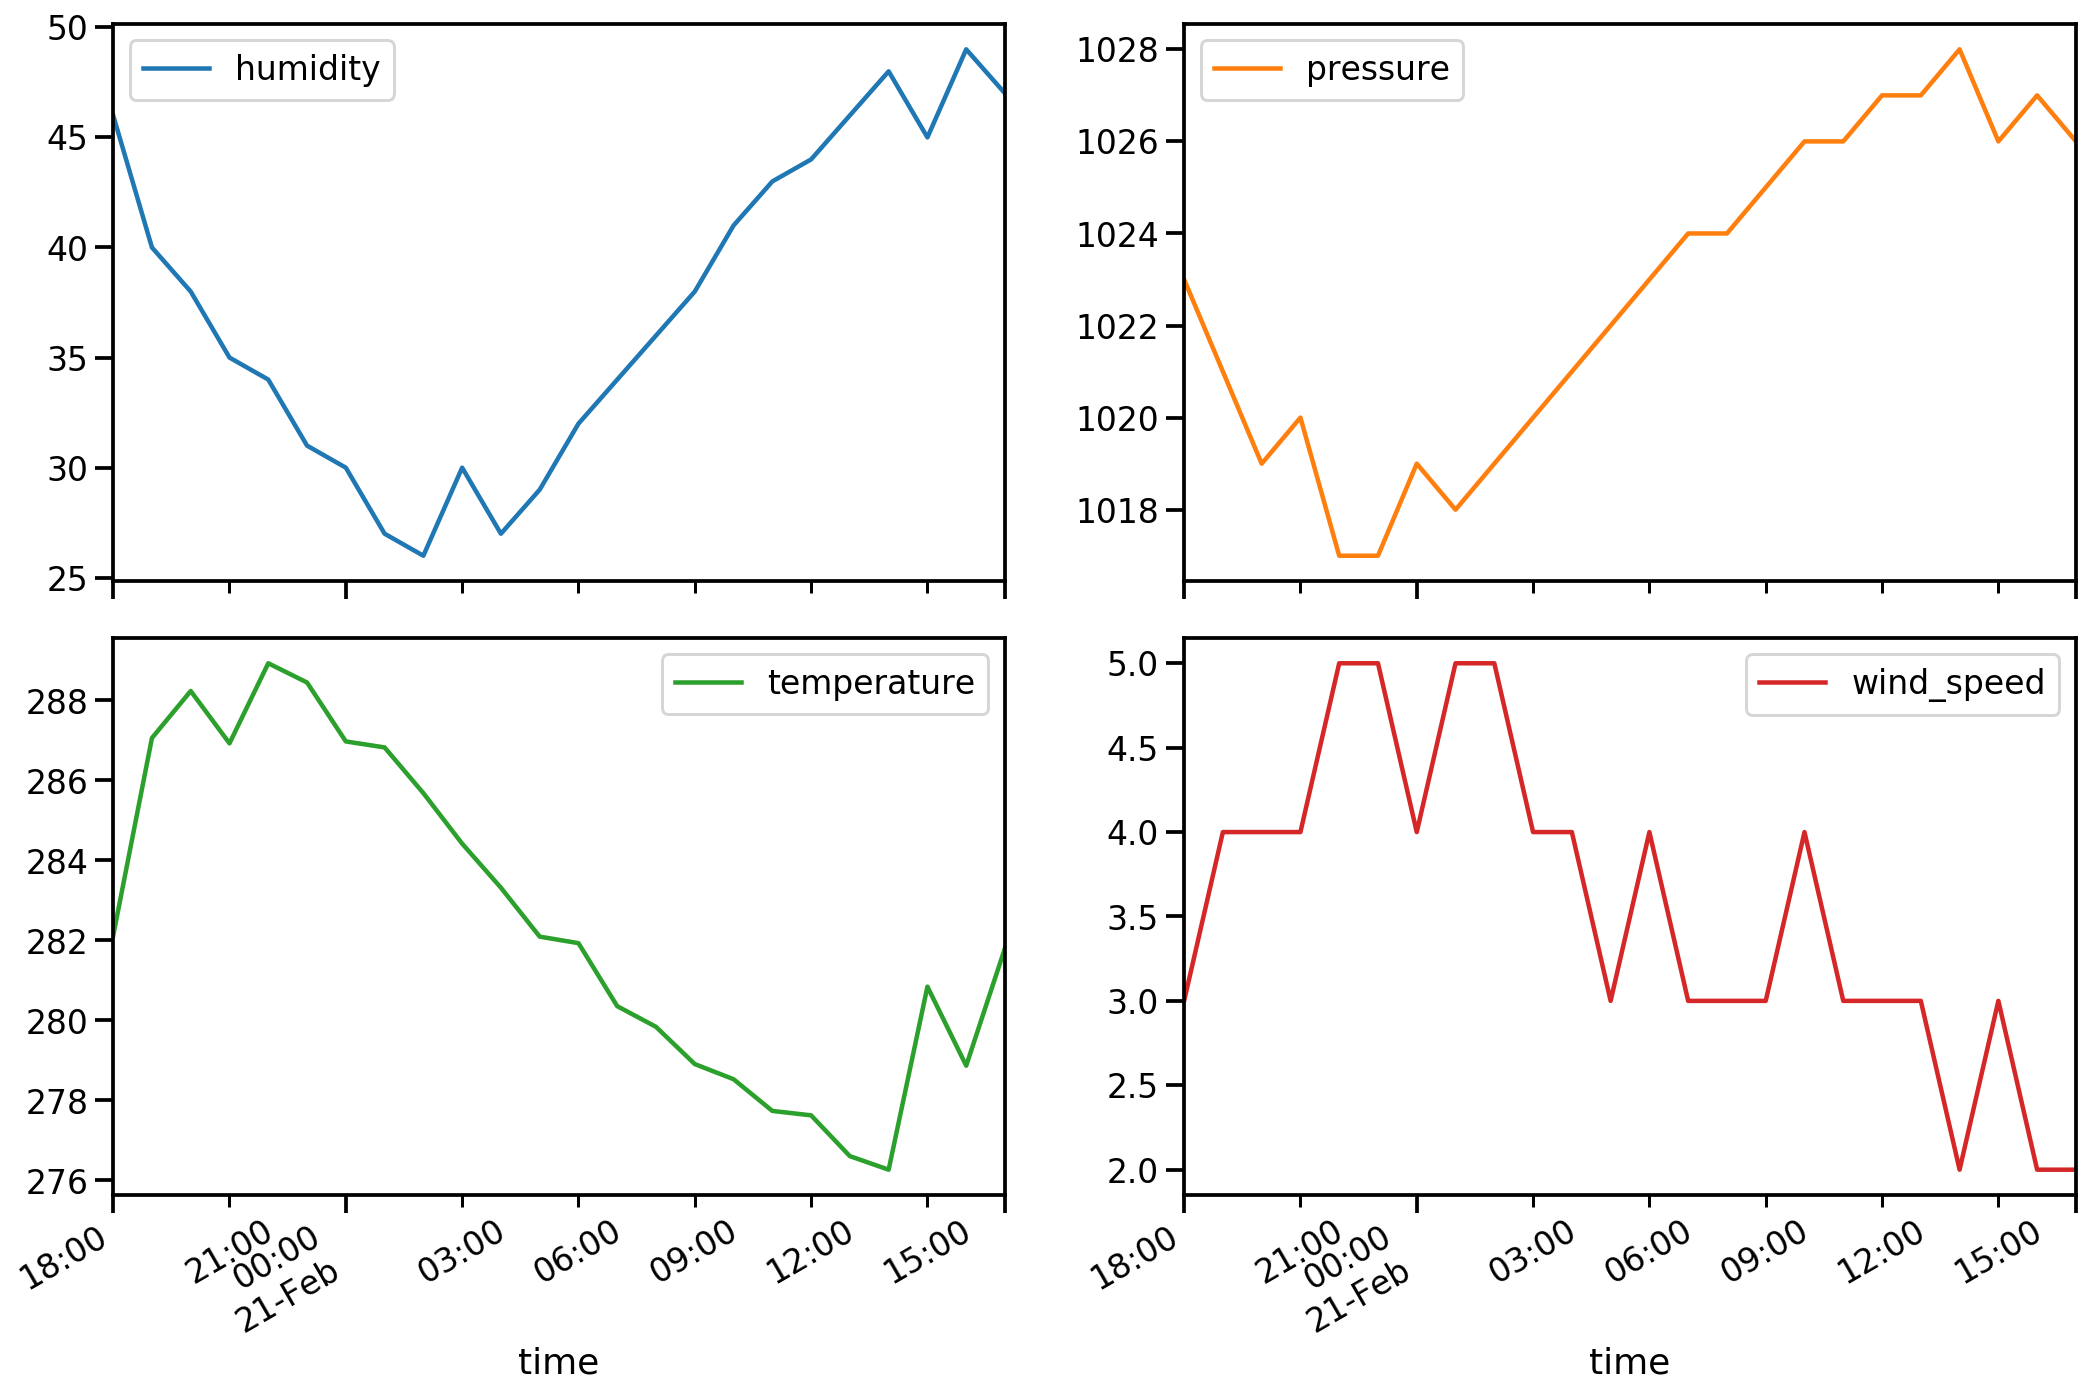

In [18]:
train_X.loc['Albuquerque/1112/1'].plot(subplots=True, layout=(2, 2), figsize=[15, 10])
plt.tight_layout()

In [31]:
# Keras RNN cells expect inputs with 3 dimensions:
# (batch_size, condition_window, features_length)
# Each RNN cell takes a vector of features_length
# at each time step of condition_window.
# Internal RNN cell state is reset between different batch samples.

# Let's review current shapes" of the input, and the desired shapes.

pd.DataFrame({
    'actual': [
        train_X.shape, 
        train_y.shape
    ],
    'expected': [
        (int(train_X.shape[0]/condition_window), condition_window, features_length), 
        (int(train_y.shape[0]/prediction_window), prediction_window)
    ],
}, index=['train_X', 'train_y'])

,actual,expected
train_X,"(826464, 4)","(34436, 24, 4)"
train_y,"(826464, 4)","(34436, 24)"


In [28]:
# Exepected shape can be achieved with a simple reshape call.
# Note that these are not Pandas data frames any more,
# but Numpy n-dimensional arrays.
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html

train_X_nd = train_X.values.reshape(-1, condition_window, features_length)
train_y_nd = train_y['temperature'].values.reshape(-1, prediction_window)

In [32]:
# Let's confirm the expected shape.
# Transforming other parts of the dataset (validate, test, and score)
# is part of the assignment scope.

pd.DataFrame({
    'actual': [
        train_X_nd.shape, 
        train_y_nd.shape
    ],
    'expected': [
        (int(train_X.shape[0]/condition_window), condition_window, features_length), 
        (int(train_y.shape[0]/prediction_window), prediction_window)
    ],
}, index=['train_X', 'train_y'])

,actual,expected
train_X,"(34436, 24, 4)","(34436, 24, 4)"
train_y,"(34436, 24)","(34436, 24)"


In [34]:
from tensorflow.python.keras.layers.recurrent import GRU
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.python import GlorotUniform

layers = [
        GRU(
            input_shape=(condition_window, features_length),
            units=100,
            return_sequences=True,
            kernel_initializer=GlorotUniform(seed=42)
        ),
        GRU(
            units=50,
            return_sequences=False,
            kernel_initializer=GlorotUniform(seed=42)
        ),
        Dense(
            units=prediction_window,
            activation='linear'
        )
]

model = Sequential(layers)

Instructions for updating:
Colocations handled automatically by placer.


In [39]:
from utils import *
from tensorflow.python.keras.optimizers import Adam

model.compile(
    optimizer=Adam(lr=0.01),
    loss='mse',
    metrics=[
        'mean_absolute_error',
        r2_score,
        mean_error
    ]
)

Instructions for updating:
Use tf.cast instead.


In [42]:
from tensorflow.python.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping

history = model.fit(
    train_X_nd,
    train_y_nd,
    epochs=2,
    batch_size=1000,
    callbacks=[
        TerminateOnNaN(),
        ReduceLROnPlateau(
            monitor='loss',
            min_delta=0.1,
            patience=5,
            cooldown=10.,
            verbose=1
        ),
        EarlyStopping(
            monitor='loss',
            min_delta=0.1,
            patience=10
        )
    ]
)

Epoch 1/2
34436/34436 [==============================] - 23s 675us/sample - loss: 65897.0932 - mean_absolute_error: 256.3874 - r2_score: -479.6242 - mean_error: -256.2635
Epoch 2/2
34436/34436 [==============================] - 25s 715us/sample - loss: 57418.4310 - mean_absolute_error: 239.2814 - r2_score: -417.4357 - mean_error: -239.1285


In [43]:
model.evaluate(train_X_nd, train_y_nd)

34436/34436 [==============================] - 38s 1ms/sample - loss: 53313.6423 - mean_absolute_error: 230.5967 - r2_score: -4559.4927 - mean_error: -230.5991


[53313.642287050614, 230.59668, -4559.4927, -230.59908]

In [48]:
pd.DataFrame(
    data=[_43],
    columns=['MSE', 'MAE', 'R2', 'ME'],
    index=['rnn']
)

,MSE,MAE,R2,ME
rnn,53313.642287,230.59668,-4559.492676,-230.599075
